In [9]:
import os
from ast import literal_eval

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

import fastestimator as fe
from fastestimator.architecture.retinanet import RetinaNet, get_fpn_anchor_box, get_target
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, ResizeImageAndBbox, TypeConverter
from fastestimator.op.tensorop import Loss, ModelOp, Pad, Rescale

In [79]:
NMS_MAX_OUTPUT = 100
INPUT_SHAPE=(512, 512, 3)
BATCH_SIZE = 8
SELECT_TOP_K = 1000

## Utilities

In [11]:
class String2List(NumpyOp):
    # this thing converts '[1, 2, 3]' into np.array([1, 2, 3])
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data

In [12]:
class GenerateTarget(NumpyOp):
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.anchorbox, _ = get_fpn_anchor_box(input_shape=INPUT_SHAPE)

    def forward(self, data, state):
        obj_label, x1, y1, width, height = data
        cls_gt, x1_gt, y1_gt, w_gt, h_gt = get_target(self.anchorbox, obj_label, x1, y1, width, height)
        return cls_gt, x1_gt, y1_gt, w_gt, h_gt

In [13]:
all_anchors, num_anchors_per_level = get_fpn_anchor_box((512, 512, 3))

In [14]:
assert all_anchors.shape == (49104, 4)

In [15]:
assert all_anchors.shape[0] == num_anchors_per_level.sum()

## Original data

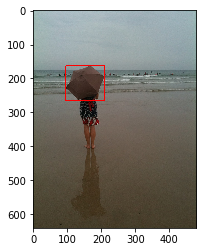

In [16]:
im = cv2.imread('/data/hsiming/dataset/MSCOCO2017/train2017/000000532867.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()

x1 = 96
y1 = 163
w = 113
h = 102

cv2.rectangle(im, (x1, y1), (x1+w, y1+h), (255, 0, 0), 2)
    
ax.imshow(im)

## Pipeline

In [17]:
train_csv = '/data/hsiming/dataset/MSCOCO2017/train_object.csv'
val_csv = '/data/hsiming/dataset/MSCOCO2017/val_object.csv'
path = '/data/hsiming/dataset/MSCOCO2017/'

In [20]:
writer = fe.RecordWriter(
    save_dir=os.path.join(path, "retinanet_coco_all"),
    train_data=train_csv,
    validation_data=val_csv,
    ops=[
        ImageReader(inputs="image", parent_path=path, outputs="image"),
        String2List(inputs=["x1", "y1", "width", "height", "obj_label"],
                    outputs=["x1", "y1", "width", "height", "obj_label"]),
        ResizeImageAndBbox(target_size=(512, 512),
                           keep_ratio=True,
                           inputs=["image", "x1", "y1", "width", "height"],
                           outputs=["image", "x1", "y1", "width", "height"]),
        GenerateTarget(inputs=("obj_label", "x1", "y1", "width", "height"),
                       outputs=("cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt", "obj_label", "x1", "y1", "width",
                                "height")),
        TypeConverter(target_type='int32', inputs=["id", "cls_gt"], outputs=["id", "cls_gt"]),
        TypeConverter(target_type='float32',
                      inputs=["x1_gt", "y1_gt", "w_gt", "h_gt"],
                      outputs=["x1_gt", "y1_gt", "w_gt", "h_gt"])
    ],
    compression="GZIP",
    write_feature=["image", "id", "cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt"])

In [21]:
# prepare pipeline
pipeline = fe.Pipeline(
    batch_size=BATCH_SIZE,
    data=writer,
    ops=[
        Rescale(inputs="image", outputs="image"),
        Pad(padded_shape=[190],
            inputs=["x1_gt", "y1_gt", "w_gt", "h_gt", "obj_label", "x1", "y1", "width", "height"],
            outputs=["x1_gt", "y1_gt", "w_gt", "h_gt", "obj_label", "x1", "y1", "width", "height"])
    ])

In [138]:
batch_data = pipeline.show_results(mode='eval', num_steps=1)

FastEstimator: Reading non-empty directory: /data/hsiming/dataset/MSCOCO2017/retinanet_coco_all
FastEstimator: Found 117266 examples for train in /data/hsiming/dataset/MSCOCO2017/retinanet_coco_all/train_summary0.json
FastEstimator: Found 4952 examples for eval in /data/hsiming/dataset/MSCOCO2017/retinanet_coco_all/eval_summary0.json


In [139]:
batch_data[0].keys()

dict_keys(['x1', 'height', 'y1', 'obj_label', 'cls_gt', 'id', 'image', 'y1_gt', 'w_gt', 'width', 'x1_gt', 'h_gt'])

In [140]:
batch_data[0]['image'].shape

TensorShape([8, 512, 512, 3])

id = 84362


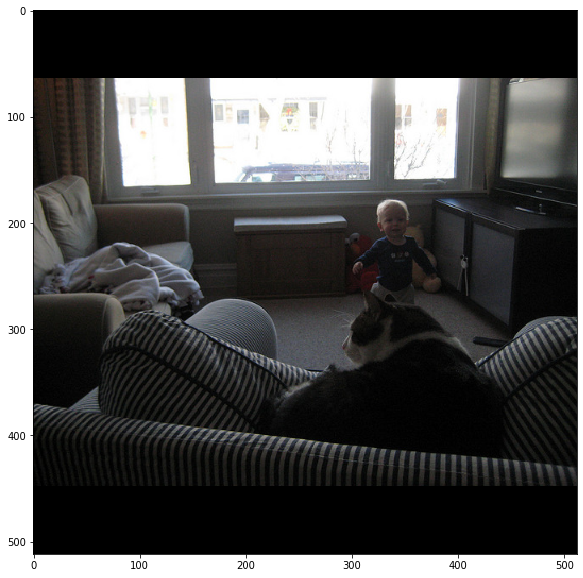

In [141]:
index = 3
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

In [26]:
gt_cls = batch_data[0]['cls_gt'].numpy()[index]

In [27]:
class_args = np.argwhere(gt_cls > 0)

In [28]:
class_args

array([[49050],
       [49051],
       [49052],
       [49053],
       [49055]])

In [29]:
gt_cls[class_args]

array([[25],
       [25],
       [25],
       [25],
       [25]], dtype=int32)

In [30]:
selected_anchors = all_anchors[class_args]

In [31]:
selected_anchors.shape

(5, 1, 4)

In [32]:
selected_anchors

array([[[256.      , 256.      , 128.      , 128.      ]],

       [[229.49033 , 274.74518 , 181.01933 ,  90.50967 ]],

       [[274.74518 , 229.49033 ,  90.50967 , 181.01933 ]],

       [[239.36505 , 239.36505 , 161.2699  , 161.2699  ]],

       [[262.98248 , 205.96497 , 114.035034, 228.07007 ]]], dtype=float32)

In [33]:
x1 = batch_data[0]['x1_gt'].numpy()[index]
y1 = batch_data[0]['y1_gt'].numpy()[index]
w = batch_data[0]['w_gt'].numpy()[index]
h = batch_data[0]['h_gt'].numpy()[index]

In [34]:
(x1[12] * selected_anchors[-1, 0, 2]) + selected_anchors[-1, 0, 0]

262.98248

In [35]:
(y1[12] * selected_anchors[-1, 0, 3]) + selected_anchors[-1, 0, 1]

205.96497

In [36]:
np.exp(w[12]) * selected_anchors[-1, 0, 2]

114.035034

In [37]:
np.exp(h[12]) * selected_anchors[-1, 0, 3]

228.07007

## Model inference 

In [193]:
trained_model = load_model('/data/hsiming/dev/retinanet_best_total_loss.h5', compile=False)
#trained_model = load_model('/data/hsiming/mscoco_model/retinanet_best_total_loss.h5', compile=False)

In [194]:
cls_pred, deltas = trained_model(batch_data[0]['image'])

In [195]:
batch_data[0].keys()

dict_keys(['x1', 'height', 'y1', 'obj_label', 'cls_gt', 'id', 'image', 'y1_gt', 'w_gt', 'width', 'x1_gt', 'h_gt'])

### TensorFlow

In [196]:
# __init__
input_shape = INPUT_SHAPE
select_top_k = SELECT_TOP_K
nms_max_outputs = NMS_MAX_OUTPUT

all_anchors, num_anchors_per_level = get_fpn_anchor_box(input_shape=input_shape)
all_anchors = tf.convert_to_tensor(all_anchors)
num_anchors_per_level = tf.convert_to_tensor(num_anchors_per_level, dtype=tf.int32)

In [197]:
def index_to_bool(indices, length):
    updates = tf.ones_like(indices, dtype=tf.bool)
    shape = tf.expand_dims(length, 0)
    is_selected = tf.scatter_nd(tf.cast(tf.expand_dims(indices, axis=-1), dtype=tf.int32), updates, shape)
    return is_selected

In [198]:
pred = []
gt = []

# extract max score and its class label
label_gt = batch_data[0]['obj_label']
x1_gt = batch_data[0]['x1']
y1_gt = batch_data[0]['y1']
w_gt = batch_data[0]['width']
h_gt = batch_data[0]['height']

labels = tf.cast(tf.argmax(cls_pred, axis=2), dtype=tf.int32)
scores = tf.reduce_max(cls_pred, axis=2)

# iterate over image
for i in range(BATCH_SIZE):
    labels_per_image = labels[i]
    scores_per_image = scores[i]
    deltas_per_image = deltas[i]

    keep_gt = label_gt[i] > 0
    label_gt_per_image = label_gt[i][keep_gt]
    x1_gt_per_image = x1_gt[i][keep_gt]
    y1_gt_per_image = y1_gt[i][keep_gt]
    w_gt_per_image = w_gt[i][keep_gt]
    h_gt_per_image = h_gt[i][keep_gt]

    selected_deltas_per_image = tf.constant([], shape=(0, 4))
    selected_labels_per_image = tf.constant([], dtype=tf.int32)
    selected_scores_per_image = tf.constant([])
    selected_anchor_indices_per_image = tf.constant([], dtype=tf.int32)

    end_index = 0
    # iterate over each pyramid level
    for j in range(num_anchors_per_level.shape[0]):
        start_index = end_index
        end_index += num_anchors_per_level[j]
        anchor_indices = tf.range(start_index, end_index, dtype=tf.int32)

        level_scores = scores_per_image[start_index:end_index]
        level_deltas = deltas_per_image[start_index:end_index]
        level_labels = labels_per_image[start_index:end_index]

        # select top k
        if num_anchors_per_level[j] >= select_top_k:
            # won't work without the tf.minimum
            top_k = tf.math.top_k(level_scores, tf.minimum(num_anchors_per_level[j], select_top_k))
            top_k_scores = top_k.values
            top_k_indices = tf.add(top_k.indices, [start_index])
        else:
            top_k_scores = level_scores
            top_k_indices = anchor_indices

        # filter out low score
        is_high_score = tf.greater(top_k_scores, 0.05)
        selected_indices = tf.boolean_mask(top_k_indices, is_high_score)
        is_selected = index_to_bool(tf.subtract(selected_indices, [start_index]),
                                         num_anchors_per_level[j])

        # combine all pyramid levels
        selected_deltas_per_image = tf.concat(
            [selected_deltas_per_image, tf.boolean_mask(level_deltas, is_selected)], axis=0)
        selected_scores_per_image = tf.concat(
            [selected_scores_per_image, tf.boolean_mask(level_scores, is_selected)], axis=0)
        selected_labels_per_image = tf.concat(
            [selected_labels_per_image, tf.boolean_mask(level_labels, is_selected)], axis=0)
        selected_anchor_indices_per_image = tf.concat(
            [selected_anchor_indices_per_image, tf.boolean_mask(anchor_indices, is_selected)], axis=0)

    # delta -> (x1, y1, w, h)
    anchor_mask = index_to_bool(selected_anchor_indices_per_image, all_anchors.shape[0])
    x1 = (selected_deltas_per_image[:, 0] * tf.boolean_mask(
        all_anchors, anchor_mask)[:, 2]) + tf.boolean_mask(all_anchors, anchor_mask)[:, 0]
    y1 = (selected_deltas_per_image[:, 1] * tf.boolean_mask(
        all_anchors, anchor_mask)[:, 3]) + tf.boolean_mask(all_anchors, anchor_mask)[:, 1]
    w = tf.math.exp(selected_deltas_per_image[:, 2]) * tf.boolean_mask(all_anchors, anchor_mask)[:, 2]
    h = tf.math.exp(selected_deltas_per_image[:, 3]) * tf.boolean_mask(all_anchors, anchor_mask)[:, 3]
    x2 = x1 + w
    y2 = y1 + h

    # nms
    boxes_per_image = tf.stack([y1, x1, y2, x2], axis=1)
    nms_indices = tf.image.non_max_suppression(boxes_per_image, selected_scores_per_image, nms_max_outputs)

    nms_boxes = tf.gather(boxes_per_image, nms_indices)
    final_scores = tf.gather(selected_scores_per_image, nms_indices)
    final_labels = tf.gather(selected_labels_per_image, nms_indices)

    x1 = tf.clip_by_value(nms_boxes[:, 1], clip_value_min=0, clip_value_max=input_shape[1])
    y1 = tf.clip_by_value(nms_boxes[:, 0], clip_value_min=0, clip_value_max=input_shape[0])
    w = tf.clip_by_value(nms_boxes[:, 3], clip_value_min=0, clip_value_max=input_shape[1]) - x1
    h = tf.clip_by_value(nms_boxes[:, 2], clip_value_min=0, clip_value_max=input_shape[0]) - y1

    final_boxes = tf.stack([x1, y1, w, h], axis=1)

    # combine image results into batch
    image_results = tf.concat([
        tf.pad(final_boxes, [[0, 0], [1, 0]], constant_values=i),
        tf.cast(tf.expand_dims(final_labels, axis=1), dtype=tf.float32),
        tf.expand_dims(final_scores, axis=1)
    ],
                              axis=1)

    image_gt = tf.transpose(
       tf.concat([
           tf.stack([i * tf.ones_like(x1_gt_per_image), x1_gt_per_image]),
           tf.expand_dims(y1_gt_per_image, axis=0),
           tf.expand_dims(w_gt_per_image, axis=0),
           tf.expand_dims(h_gt_per_image, axis=0),
           tf.expand_dims(label_gt_per_image, axis=0)
       ],
                 axis=0))
    pred.append(image_results)
    gt.append(image_gt)

In [199]:
tf_pred = tf.concat(pred, axis=0)
tf_gt = tf.concat(gt, axis=0)

In [202]:
tf_gt

<tf.Tensor: id=129771, shape=(43, 6), dtype=int32, numpy=
array([[  0,   5, 166, 498, 266,  61],
       [  0,   0,  93, 512, 349,  67],
       [  1, 368, 325,  81,  71,  77],
       [  1, 114,  88, 397, 335,   1],
       [  1,   0, 259, 199, 159,  73],
       [  1,   2, 147,  46, 118,  44],
       [  2, 149, 144, 275, 297,   1],
       [  2, 227, 158, 141,  67,  39],
       [  3, 425,  64,  86, 121,  72],
       [  3, 208, 264, 235, 157,  17],
       [  3, 189, 140, 128,  21,   8],
       [  3, 299, 177,  80,  96,   1],
       [  3,   0, 271, 512, 176,  62],
       [  3, 413, 307,  34,   9,  75],
       [  3,   0, 151, 159, 223,  63],
       [  3,   0, 283, 512, 159,  63],
       [  4,  25, 326, 200,  99,  81],
       [  5, 287, 138, 111,  32,   3],
       [  5, 392, 149,  99,  26,   3],
       [  5,  37, 218, 176, 225,   1],
       [  5,  69, 147,  33,  28,   1],
       [  5,  52, 141,  21,  34,   1],
       [  5,   2, 319, 277,  92,  15],
       [  5,  98, 249,  77,  48,  73],
      

In [206]:
x1_gt

array([425, 208, 189, 299,   0, 413,   0,   0], dtype=int32)

id = 84362


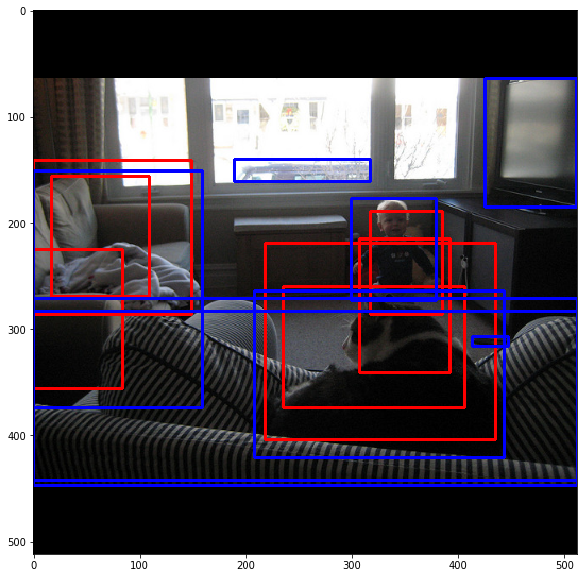

In [210]:
index = 3
keep = tf.where(tf.equal(tf_pred[:, 0], index), True, False)
keep_gt = tf.where(tf.equal(tf_gt[:, 0], index), True, False)

x1 = tf_pred[keep][:, 1].numpy()
y1 = tf_pred[keep][:, 2].numpy()
w = tf_pred[keep][:, 3].numpy()
h = tf_pred[keep][:, 4].numpy()
x2 = x1 + w
y2 = y1 + h

x1_gt = tf_gt[keep_gt][:, 1].numpy()
y1_gt = tf_gt[keep_gt][:, 2].numpy()
w_gt = tf_gt[keep_gt][:, 3].numpy()
h_gt = tf_gt[keep_gt][:, 4].numpy()
x2_gt = x1_gt + w_gt
y2_gt = y1_gt + h_gt


img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

for i in range(np.min([10, batch_boxes[index].shape[0]])):
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)
    
for j in range(len(x1_gt)):
    cv2.rectangle(img, (x1_gt[j], y1_gt[j]), (x2_gt[j], y2_gt[j]), (0, 0, 255), 2)
    
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

#### tf old implementation

In [46]:
num_anchors_per_level

array([36864,  9216,  2304,   576,   144], dtype=int32)

In [47]:
def index_to_bool(indices, length):
    updates = tf.ones_like(indices, dtype=tf.bool)
    shape = tf.constant([length], dtype=tf.int64)
    is_selected = tf.scatter_nd(tf.cast(tf.expand_dims(indices, axis=-1), dtype=tf.int64), updates, shape)
    return is_selected

In [48]:
# tensorflow

batch_boxes = []
batch_score = []
batch_cls = []
#batch_anchor_indices = [] # for debug only

select_top_k = 1000

# for each image
for i in range(score.shape[0]):
    cls_pred_per_image = cls_pred[i]
    score_per_image = score[i]
    delta_per_image = delta[i]
    end_index = 0
    
    selected_delta_per_image = tf.transpose(tf.constant([[], [], [], []]))
    selected_cls_per_image = tf.constant([], dtype=tf.int64)
    selected_score_per_image = tf.constant([])
    selected_anchor_indices_per_image = tf.constant([], dtype=tf.int64)
    
    # for each pyramid level in one image
    for j in range(len(num_anchors_per_level)):
        start_index = end_index
        end_index += num_anchors_per_level[j]

        
        level_score = score_per_image[start_index:end_index]  
        level_delta = delta_per_image[start_index:end_index, :]
        level_cls_pred = cls_pred_per_image[start_index:end_index]
        anchor_indices = tf.range(start_index, end_index, dtype=tf.int64)
        
        # select top 1k
        if num_anchors_per_level[j] >= select_top_k:
            top_k = tf.math.top_k(level_score, select_top_k)
            top_k_scores = top_k.values
            top_k_indices = tf.add(top_k.indices, [start_index])
        else:
            top_k_scores = level_score
            top_k_indices = anchor_indices
        
        # filter out low score
        is_high_score = tf.greater(top_k_scores, 0.05)  
        selected_indices = tf.boolean_mask(top_k_indices, is_high_score)
        
        is_selected = index_to_bool(tf.subtract(selected_indices, [start_index]), level_delta.shape[0])
        
        # combine all levels in one image
        selected_delta_per_image = tf.concat([selected_delta_per_image, tf.boolean_mask(level_delta, is_selected)], axis=0)
        selected_score_per_image = tf.concat([selected_score_per_image, tf.boolean_mask(level_score, is_selected)], axis=0)
        selected_cls_per_image = tf.concat([selected_cls_per_image, tf.boolean_mask(level_cls_pred, is_selected)], axis=0)
        selected_anchor_indices_per_image = tf.concat([selected_anchor_indices_per_image, tf.boolean_mask(anchor_indices, is_selected)], axis=0)
    
    # apply delta
    anchor_mask = index_to_bool(selected_anchor_indices_per_image, all_anchors.shape[0])
    x1 = (selected_delta_per_image[:, 0] * tf.boolean_mask(all_anchors, anchor_mask)[:, 2]) + tf.boolean_mask(all_anchors, anchor_mask)[:, 0]    
    y1 = (selected_delta_per_image[:, 1] * tf.boolean_mask(all_anchors, anchor_mask)[:, 3]) + tf.boolean_mask(all_anchors, anchor_mask)[:, 1]    
    w = tf.math.exp(selected_delta_per_image[:, 2]) * tf.boolean_mask(all_anchors, anchor_mask)[:, 2]
    h = tf.math.exp(selected_delta_per_image[:, 3]) * tf.boolean_mask(all_anchors, anchor_mask)[:, 3]
    x2 = x1 + w
    y2 = y1 + h
    
    # nms 
    boxes_per_image = tf.stack([y1, x1, y2, x2], axis=1)
    nms_indices = tf.image.non_max_suppression(boxes_per_image, selected_score_per_image, NMS_MAX_OUTPUT)
    #nms_indices = nms.selected_indices[:nms.valid_outputs]
    nms_boxes = tf.gather(boxes_per_image, nms_indices)
    x1 = tf.clip_by_value(nms_boxes[:, 1], clip_value_min=0, clip_value_max=INPUT_SHAPE[1])
    y1 = tf.clip_by_value(nms_boxes[:, 0], clip_value_min=0, clip_value_max=INPUT_SHAPE[0])
    w = tf.clip_by_value(nms_boxes[:, 3], clip_value_min=0, clip_value_max=INPUT_SHAPE[1]) - x1
    h = tf.clip_by_value(nms_boxes[:, 2], clip_value_min=0, clip_value_max=INPUT_SHAPE[0]) - y1
    final_boxes = tf.stack([x1, y1, w, h], axis=1)
    
    final_score = tf.gather(selected_score_per_image, nms_indices)
    final_cls = tf.gather(selected_cls_per_image, nms_indices)
    
    # create batch  
    print("i = {}, valid anchors = {}".format(i, nms_indices.shape[0]))
    # pad to NMS_MAX_OUTPUT
#     padding = NMS_MAX_OUTPUT - nms.valid_outputs
#     padded_boxes = tf.pad(final_boxes, [[0, padding], [0, 0]], constant_values=-1)
#     padded_score = tf.pad(final_score, [[0, padding]], constant_values=-1)
#     padded_cls = tf.pad(final_cls, [[0, padding]], constant_values=-1)
    image_results = tf.concat([tf.pad(final_boxes, [[0, 0], [1, 0]], constant_values=i), tf.cast(tf.expand_dims(final_cls, axis=1), dtype=tf.float32), tf.expand_dims(final_score, axis=1)], axis=1)
    batch_boxes.append(image_results)
#     batch_boxes.append(final_boxes) 
#     batch_score.append(final_score)
#     batch_cls.append(final_cls)
    
    #batch_anchor_indices.append(tf.gather(selected_anchor_indices_per_image, nms_indices.selected_indices))

i = 0, valid anchors = 15
i = 1, valid anchors = 75
i = 2, valid anchors = 15
i = 3, valid anchors = 7
i = 4, valid anchors = 25
i = 5, valid anchors = 3
i = 6, valid anchors = 31
i = 7, valid anchors = 100


In [49]:
tf.concat(batch_boxes, axis=0)

<tf.Tensor: id=19264, shape=(271, 7), dtype=float32, numpy=
array([[0.0000000e+00, 5.9709412e+01, 2.3871817e+02, ..., 2.4650180e+02,
        7.0000000e+01, 5.3858697e-01],
       [0.0000000e+00, 2.3770395e+02, 2.4637778e+02, ..., 1.6451968e+02,
        7.0000000e+01, 2.1702334e-01],
       [0.0000000e+00, 8.5773117e+01, 2.5827759e+02, ..., 1.4589847e+02,
        7.0000000e+01, 1.7265746e-01],
       ...,
       [7.0000000e+00, 2.5970184e+02, 1.7224388e+02, ..., 1.3813950e+01,
        4.7000000e+01, 6.7296594e-02],
       [7.0000000e+00, 2.7273901e+02, 4.2376953e+02, ..., 3.1327606e+01,
        4.7000000e+01, 6.6886812e-02],
       [7.0000000e+00, 3.2545026e+02, 1.9575613e+02, ..., 3.6193787e+01,
        8.1000000e+01, 6.6706508e-02]], dtype=float32)>

id = 305813


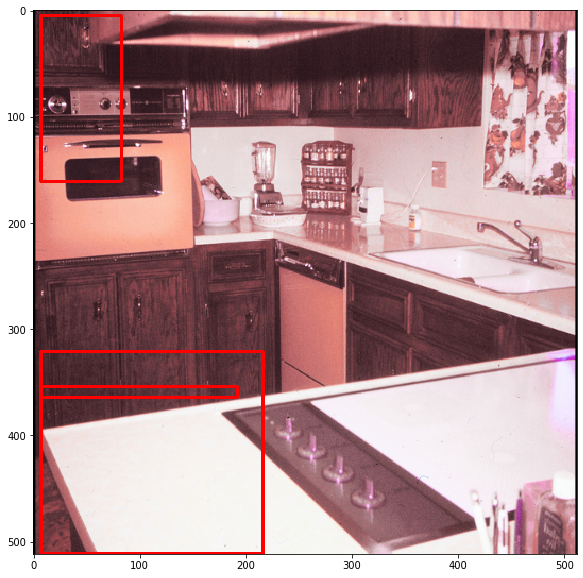

In [50]:
index = 7
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

x1 = batch_boxes[index][:, 0]
y1 = batch_boxes[index][:, 1]
x2 = x1 + batch_boxes[index][:, 2]
y2 = y1+ batch_boxes[index][:, 3]

for i in range(np.min([3, batch_boxes[index].shape[0]])):
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)
    #print([x1[i].numpy(), y1[i].numpy(), x2[i].numpy(), y2[i].numpy()])
    
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

### Numpy

In [169]:
cls = np.squeeze(cls.numpy())
delta = np.squeeze(delta.numpy())

In [170]:
# numpy
end_index = 0

selected_delta = []
selected_score = []
selected_cls = []
selected_anchor_indices = []

select_top = 1000

# loop through each pyramid level
for i in range(len(num_anchors_per_level)):
    start_index = end_index
    end_index += num_anchors_per_level[i]
    
    anchor_indices = np.arange(start_index, end_index)
    level_score = score.numpy()[index, anchor_indices]
    
    # select top 1k
    if num_anchors_per_level[i] >= select_top:
        topk_indices = np.argsort(-level_score)[:select_top]  # negative sign for descending order
    else:
        topk_indices = np.array(range(len(level_score)))
        
    # filter out low score
    is_high_score = level_score[topk_indices] > 0.05
    selected_indices = topk_indices[is_high_score]
    
    selected_score.append(level_score[selected_indices])
    
    selected_delta.append(delta[index].numpy()[anchor_indices, :][selected_indices, :])
    selected_cls.append(cls_pred[index].numpy()[anchor_indices][selected_indices])
    selected_anchor_indices.append(anchor_indices[selected_indices])

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [52]:
selected_score = np.concatenate(selected_score, axis=0)
selected_delta = np.concatenate(selected_delta, axis=0)
selected_cls = np.concatenate(selected_cls, axis=0)
selected_anchor_indices = np.concatenate(selected_anchor_indices, axis=0)

In [53]:
descend = np.argsort(-selected_score)

In [54]:
selected_score = selected_score[descend]
selected_delta = selected_delta[descend, :]
selected_cls = selected_cls[descend]
selected_anchor_indices = selected_anchor_indices[descend]

In [55]:
selected_score.shape

(431,)

In [56]:
selected_delta.shape

(431, 4)

In [57]:
selected_cls.shape

(431,)

In [58]:
selected_anchor_indices.shape

(431,)

In [59]:
selected_score

array([0.50241745, 0.48188382, 0.4772439 , 0.46285275, 0.44272485,
       0.41886717, 0.40966845, 0.39195782, 0.39081785, 0.38019472,
       0.3636762 , 0.35486186, 0.33677822, 0.32434553, 0.31405437,
       0.30432558, 0.2920101 , 0.2799297 , 0.27495745, 0.26566404,
       0.2501219 , 0.24572542, 0.24408013, 0.24291322, 0.22248128,
       0.2217404 , 0.21865404, 0.20685938, 0.20460686, 0.19863781,
       0.19265461, 0.19258383, 0.18274263, 0.18010601, 0.17819333,
       0.17629868, 0.17608541, 0.17601854, 0.17383075, 0.16828597,
       0.166152  , 0.16536674, 0.16518629, 0.16324526, 0.15371788,
       0.15200442, 0.15040421, 0.15038821, 0.14885154, 0.14737645,
       0.14678714, 0.1465095 , 0.14649618, 0.1450721 , 0.14479256,
       0.14367712, 0.14284208, 0.14003402, 0.13842714, 0.13662359,
       0.13385776, 0.13162798, 0.13151947, 0.13061723, 0.12853476,
       0.12828594, 0.12411323, 0.12335128, 0.12316906, 0.1220808 ,
       0.12117955, 0.1200687 , 0.11999062, 0.11894339, 0.11817

#### Apply deltas

In [60]:
x1 = (selected_delta[:, 0] * all_anchors[selected_anchor_indices][:, 2]) + all_anchors[selected_anchor_indices][:, 0]

In [61]:
y1 = (selected_delta[:, 1] * all_anchors[selected_anchor_indices][:, 3]) + all_anchors[selected_anchor_indices][:, 1]

In [62]:
w = np.exp(selected_delta[:, 2]) * all_anchors[selected_anchor_indices][:, 2]

In [63]:
h = np.exp(selected_delta[:, 3]) * all_anchors[selected_anchor_indices][:, 3]

In [64]:
x2 = x1 + w

In [65]:
y2 = y1 + h

In [66]:
# img = batch_data[0]['image'].numpy()[index]
# img = ((img + 1) / 2 * 255).astype(np.uint8)


# for i in range(4):
#     cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)

# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(img)

# print("id = {}".format(batch_data[0]['id'].numpy()[index]))

#### NMS

In [67]:
boxes = np.vstack([y1, x1, y2, x2]).T

In [68]:
final_boxes = tf.image.non_max_suppression(boxes, selected_score, NMS_MAX_OUTPUT)

In [69]:
assert np.array_equal(selected_anchor_indices[final_boxes.numpy()], batch_anchor_indices[index].numpy())

NameError: name 'batch_anchor_indices' is not defined

[354.29724, 185.57544, 364.7262, 219.0878]
[5.73412, 76.74985, 161.62878, 223.66951]
[321.87976, 209.45633, 511.41574, 264.88437]
id = 305813


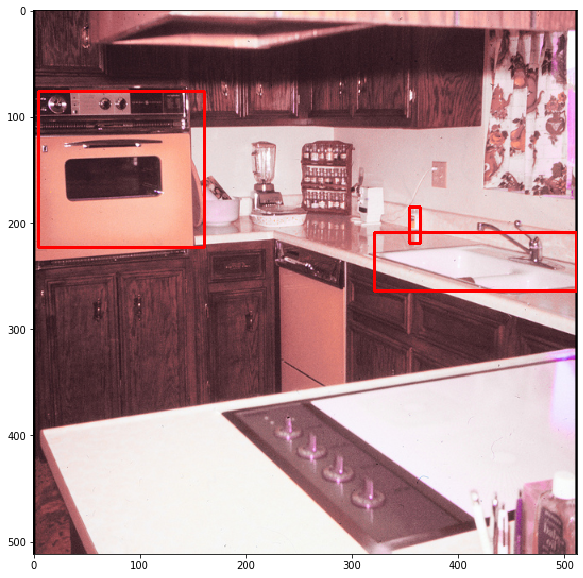

In [70]:
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

for i in final_boxes.numpy()[:3]:
    print([x1[i], y1[i], x2[i], y2[i]])
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

id = 305813


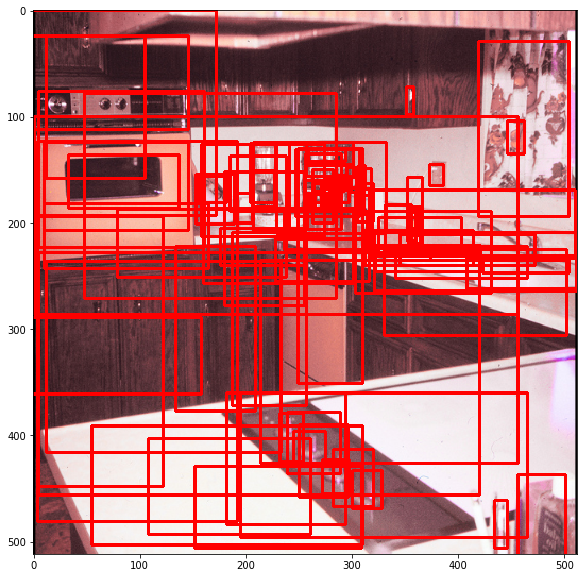

In [71]:
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)


for i in final_boxes.numpy():
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))